In [109]:
import cv2
import numpy as np
import pandas as pd
from typing import Any
from random import randint
from matplotlib import pyplot as plt

Type Declarations and Helpful Functions

In [107]:
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: np.ndarray) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_largest_contours(img: cv2.Image, n: int = 1, debug: bool = False) -> list[cv2.Contour]:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 100, 255, 0)[1]
    if debug: imshow(thresh) 
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    if n == 1:
        return [max(contours, key=cv2.contourArea)]
    return sorted(contours, key=cv2.contourArea, reverse=True)[:n]

Loads the spreadsheet

In [8]:
SHEET_DATA = pd.read_excel("./data.xlsx")
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core"
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core"


Segments the leaves from the image

dataset/7621CBDE-5EF2-4988-BD56-A44FFAD7CAA7.jpg


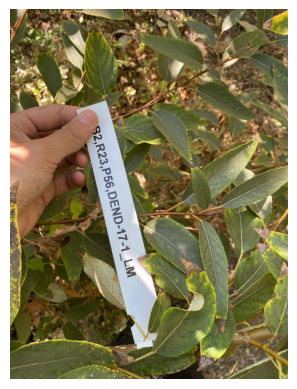

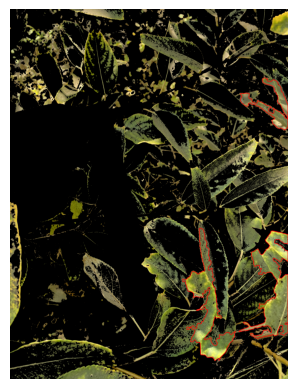

In [114]:
def get_leaves(img: cv2.Image, debug: bool = True) -> Any:
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_img, (20, 70, 100), (80, 255, 255))
    masked = cv2.bitwise_and(img, img, mask=mask)
    biggest_leaves = get_largest_contours(masked, 3, debug=False)
    masked = cv2.drawContours(masked, biggest_leaves, -1, (0, 0, 255), 5)
    if debug: imshow(masked)

filename = f"dataset/{SHEET_DATA['filename'][randint(0, len(SHEET_DATA)-1)]}"
print(filename)
img = cv2.imread(filename)
imshow(img)
get_leaves(img, debug=True)